# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [7]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [8]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [32]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.339298
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** When we random guess the result. It should be have 10% chance to get correct. So our log loss should be np.log(0.1).


In [31]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.826808 analytic: -0.826808, relative error: 4.584312e-08
numerical: -1.254219 analytic: -1.254219, relative error: 4.040309e-08
numerical: -0.514452 analytic: -0.514452, relative error: 3.185375e-08
numerical: 1.486662 analytic: 1.486662, relative error: 2.783548e-08
numerical: 2.129493 analytic: 2.129493, relative error: 3.774177e-08
numerical: -0.433035 analytic: -0.433035, relative error: 5.240919e-08
numerical: 2.289338 analytic: 2.289338, relative error: 1.903047e-08
numerical: -0.026753 analytic: -0.026754, relative error: 1.844894e-06
numerical: -1.281418 analytic: -1.281418, relative error: 2.838998e-08
numerical: -3.526111 analytic: -3.526111, relative error: 1.910219e-09
numerical: 2.443095 analytic: 2.443095, relative error: 3.137354e-08
numerical: 2.584367 analytic: 2.584367, relative error: 2.409151e-08
numerical: -2.074389 analytic: -2.074389, relative error: 1.250846e-08
numerical: 2.486436 analytic: 2.486436, relative error: 2.763879e-08
numerical: 0.49587

In [59]:
score = X_dev.dot(W)
logit = np.exp(score)/np.sum(np.exp(score),axis=1).reshape(500,1)

In [71]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.339298e+00 computed in 0.136729s
vectorized loss: 2.339298e+00 computed in 0.005113s
Loss difference: 0.000000
Gradient difference: 0.000000


In [73]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7,1e-6,1e-5,1e-4,1e-3]
regularization_strengths = [2.5e4, 5e4,5e3,1e2,5,5e-1,2.5e-2]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        print("lr and reg is ", lr, reg)
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                          num_iters=1200, verbose=True)
        y_train_pred = softmax.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        valid_acc = np.mean(y_val == y_val_pred)
        if valid_acc > best_val:
            best_val = valid_acc
            best_softmax = softmax
        results[(lr,reg)] = (train_acc,valid_acc)

# pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr and reg is  1e-07 25000.0
iteration 0 / 1200: loss 391.085752
iteration 100 / 1200: loss 236.327894
iteration 200 / 1200: loss 143.927928
iteration 300 / 1200: loss 87.667985
iteration 400 / 1200: loss 53.867934
iteration 500 / 1200: loss 33.264136
iteration 600 / 1200: loss 20.970688
iteration 700 / 1200: loss 13.416810
iteration 800 / 1200: loss 9.042166
iteration 900 / 1200: loss 6.207458
iteration 1000 / 1200: loss 4.562312
iteration 1100 / 1200: loss 3.573249
lr and reg is  1e-07 50000.0
iteration 0 / 1200: loss 783.854666
iteration 100 / 1200: loss 287.966380
iteration 200 / 1200: loss 106.628421
iteration 300 / 1200: loss 40.284638
iteration 400 / 1200: loss 16.092220
iteration 500 / 1200: loss 7.182311
iteration 600 / 1200: loss 3.984918
iteration 700 / 1200: loss 2.776927
iteration 800 / 1200: loss 2.324227
iteration 900 / 1200: loss 2.157483
iteration 1000 / 1200: loss 2.128265
iteration 1100 / 1200: loss 2.134455
lr and reg is  1e-07 5000.0
iteration 0 / 1200: loss 81.839

iteration 900 / 1200: loss 3.509505
iteration 1000 / 1200: loss 3.102522
iteration 1100 / 1200: loss 3.099729
lr and reg is  1e-06 5
iteration 0 / 1200: loss 5.061700
iteration 100 / 1200: loss 2.825761
iteration 200 / 1200: loss 2.567951
iteration 300 / 1200: loss 2.464449
iteration 400 / 1200: loss 2.497909
iteration 500 / 1200: loss 2.408529
iteration 600 / 1200: loss 2.201556
iteration 700 / 1200: loss 2.253807
iteration 800 / 1200: loss 2.063340
iteration 900 / 1200: loss 2.038828
iteration 1000 / 1200: loss 2.071362
iteration 1100 / 1200: loss 2.123347
lr and reg is  1e-06 0.5
iteration 0 / 1200: loss 5.754034
iteration 100 / 1200: loss 2.822827
iteration 200 / 1200: loss 2.520409
iteration 300 / 1200: loss 2.537931
iteration 400 / 1200: loss 2.271469
iteration 500 / 1200: loss 2.225918
iteration 600 / 1200: loss 2.289525
iteration 700 / 1200: loss 2.303528
iteration 800 / 1200: loss 2.225554
iteration 900 / 1200: loss 2.117862
iteration 1000 / 1200: loss 2.288480
iteration 1100 

/Users/Rocha/Documents/Github/cs231n-exec/assignment1/cs231n/classifiers/softmax.py:80: RuntimeWarning: divide by zero encountered in log
  loss += -np.sum(np.log(logit[:,y]))
/Users/Rocha/Documents/Github/cs231n-exec/assignment1/cs231n/classifiers/softmax.py:79: RuntimeWarning: overflow encountered in exp
  logit = np.exp(score)/np.sum(np.exp(score),axis=1).reshape(num_train,1)
/Users/Rocha/Documents/Github/cs231n-exec/assignment1/cs231n/classifiers/softmax.py:79: RuntimeWarning: invalid value encountered in true_divide
  logit = np.exp(score)/np.sum(np.exp(score),axis=1).reshape(num_train,1)


iteration 100 / 1200: loss nan
iteration 200 / 1200: loss nan
iteration 300 / 1200: loss nan
iteration 400 / 1200: loss nan
iteration 500 / 1200: loss nan
iteration 600 / 1200: loss nan
iteration 700 / 1200: loss nan
iteration 800 / 1200: loss nan
iteration 900 / 1200: loss nan
iteration 1000 / 1200: loss nan
iteration 1100 / 1200: loss nan
lr and reg is  0.0001 50000.0
iteration 0 / 1200: loss 774.967302
iteration 100 / 1200: loss nan
iteration 200 / 1200: loss nan
iteration 300 / 1200: loss nan
iteration 400 / 1200: loss nan
iteration 500 / 1200: loss nan
iteration 600 / 1200: loss nan
iteration 700 / 1200: loss nan
iteration 800 / 1200: loss nan
iteration 900 / 1200: loss nan
iteration 1000 / 1200: loss nan
iteration 1100 / 1200: loss nan
lr and reg is  0.0001 5000.0
iteration 0 / 1200: loss 81.152953
iteration 100 / 1200: loss 97.923797
iteration 200 / 1200: loss 103.506846
iteration 300 / 1200: loss 66.280609
iteration 400 / 1200: loss 102.887926
iteration 500 / 1200: loss 61.6336

In [77]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.383000


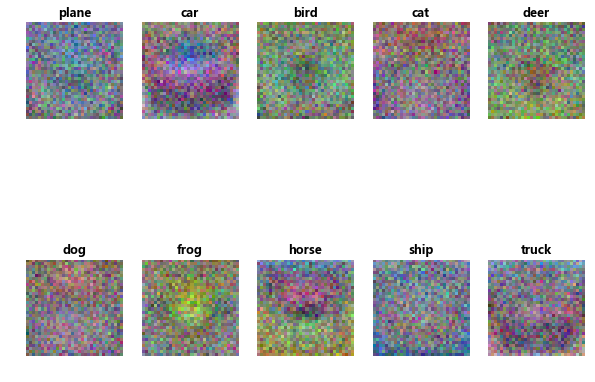

In [78]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])